## Do the Estimation with SCE and SPF data for UCSV model


### 1. Importing estimation codes

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np

from scipy.optimize import minimize

import statsmodels.api as sm
#from statsmodels.tsa.api import AR
#from UCSVEst import UCSVEst as ucsv

In [11]:
from GMMEstSV import RationalExpectationSV as resv
from GMMEstSV_dev import StickyExpectationSV as sesv
from GMMEstSV_dev import NoisyInformationSV as nisv
#from GMMEstSV import ParameterLearningSV as plsv
from GMMEstSV import UCSV_simulator, ForecastPlotDiag, ForecastPlot

### 2. Preparing real-time data 

In [12]:
## CPI Core
InfCPICMRT = pd.read_stata('../OtherData/InfCPICMRealTime.dta')  
InfCPICMRT = InfCPICMRT[-InfCPICMRT.date.isnull()]

## CPI 
InfCPIMRT = pd.read_stata('../OtherData/InfCPIMRealTime.dta')  
InfCPIMRT = InfCPIMRT[-InfCPIMRT.date.isnull()]

In [13]:
## dealing with dates 
dateM_cpic = pd.to_datetime(InfCPICMRT['date'],format='%Y%m%d')
dateM_cpi = pd.to_datetime(InfCPIMRT['date'],format='%Y%m%d')

InfCPICMRT.index = pd.DatetimeIndex(dateM_cpic,freq='infer')
InfCPIMRT.index = pd.DatetimeIndex(dateM_cpi,freq='infer')

In [14]:
## a function that turns vintage matrix to a one-dimension vector of real time data
def GetRealTimeData(matrix):
    periods = len(matrix)
    real_time = np.zeros(periods)
    for i in range(periods):
        real_time[i] = matrix.iloc[i,i+1]
    return real_time

In [15]:
## generate real-time series 
matrix_cpic = InfCPICMRT.copy().drop(columns=['date','year','month'])
matrix_cpi = InfCPIMRT.copy().drop(columns=['date','year','month'])

real_time_cpic = pd.Series(GetRealTimeData(matrix_cpic) )
real_time_cpi =  pd.Series(GetRealTimeData(matrix_cpi) ) 
real_time_cpic.index =  InfCPICMRT.index #+ pd.DateOffset(months=1) 
real_time_cpi.index = InfCPIMRT.index #+ pd.DateOffset(months=1)

In [16]:
## turn index into yearly inflation
real_time_index = pd.concat([real_time_cpic,real_time_cpi], 
                            join='inner', 
                            axis=1)
real_time_index.columns=['RTCPI','RTCPICore']
real_time_inf = real_time_index.pct_change(periods=12)*100

In [17]:
real_time_inf.tail()

,RTCPI,RTCPICore
date,,
2019-03-01,2.019516,1.878442
2019-04-01,2.060831,1.977897
2019-05-01,2.002032,1.844054
2019-06-01,2.136764,1.773122
2019-07-01,2.186252,1.940021


### 3. Estimating using real-time inflation and expectation data


In [18]:
## exapectation data from SPF 

PopQ = pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]
dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')


## expectation data from SCE

PopM = pd.read_stata('../SurveyData/InfExpM.dta')
PopM = PopM[-PopM.date.isnull()]
dateM = pd.to_datetime(PopM['date'],format='%Y%m%d')
dateM_str = dateM.dt.year.astype(int).astype(str) + \
             "M" + dateM.dt.month.astype(int).astype(str)
PopM.index = pd.DatetimeIndex(dateM)
SCECPI = PopM[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']].dropna(how='any')

In [19]:
## inflation data 

## quarterly 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],
                        format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2,freq='infer')


## monthly
InfM = pd.read_stata('../OtherData/InfShocksMClean.dta')
InfM = InfM[-InfM.date.isnull()]
dateM = pd.to_datetime(InfM['date'],format='%Y%m%d')
#dateM_str = dateM .dt.year.astype(int).astype(str) + \
#             "M" + dateM .dt.month.astype(int).astype(str)
InfM.index = pd.DatetimeIndex(dateM,freq='infer')

In [20]:
## process parameters estimation 

# period filter 
start_t ='1995-01-01'
end_t = '2019-03-30'   

################
## quarterly ##
################

### quarterly data 
CPICQ = InfQ['Inf1y_CPICore'].copy().loc[start_t:end_t]

### exporting inflation series for process estimation using UCSV model in matlab

CPICQ.to_excel("../OtherData/CPICQ.xlsx")  ## this is for matlab estimation of UCSV model

CPICQ_UCSV_Est = pd.read_excel('../OtherData/UCSVestQ.xlsx',
                               header = None)  
CPICQ_UCSV_Est.columns = ['sd_eta_est','sd_eps_est','tau']  ## Loading ucsv model estimates 


################
## monthly ####
################

### process parameters estimation 

CPIM = InfM['Inf1y_CPIAU'].copy().loc[start_t:end_t]

### exporting monthly inflation series for process estimation using UCSV model in matlab
CPIM.to_excel("../OtherData/CPIM.xlsx")  ## this is for matlab estimation of UCSV model

CPIM_UCSV_Est = pd.read_excel('../OtherData/UCSVestM.xlsx',header=None)  
CPIM_UCSV_Est.columns = ['sd_eta_est','sd_eps_est','tau']  ## Loading ucsv model estimates 

########################################################################################
## be careful with the order, I define eta as the permanent and eps to be the tansitory 
 ######################################################################################

In [21]:
## Combine expectation data and real-time data 

SPF_est = pd.concat([SPFCPI,real_time_inf,
                     InfQ['Inf1y_CPICore'],
                     InfQ['Inf1yf_CPICore']], 
                    join='inner', 
                    axis=1)
SCE_est = pd.concat([SCECPI,
                     real_time_inf,
                     InfM['Inf1yf_CPIAU']], 
                    join='inner', 
                    axis=1)

In [22]:
## hisotries data, the series ends at the same dates with real-time data but startes earlier 

st_t_history = '2000-01-01'
ed_t_SPF = SPF_est.index[-1].strftime('%Y%m%d')
ed_t_SCE = SCE_est.index[-1].strftime('%Y-%m-%d')

## get the quarterly index 
indexQ = CPICQ.index

historyQ = real_time_inf.copy()[real_time_inf.index.isin(indexQ)].loc[st_t_history:ed_t_SPF,:]
historyM = real_time_inf.copy().loc[st_t_history:ed_t_SCE,:]

#########################################################
## specific to stochastic vol model  
######################################################

#############
## quarterly 
##############

n_burn_rt_historyQ = len(CPICQ_UCSV_Est) - len(historyQ)  

history_vol_etaQ = np.array(CPICQ_UCSV_Est['sd_eta_est'][n_burn_rt_historyQ:])**2  ## permanent
history_vol_epsQ = np.array(CPICQ_UCSV_Est['sd_eps_est'][n_burn_rt_historyQ:])**2 ## transitory
history_volsQ = np.array([history_vol_etaQ,
                          history_vol_epsQ])
history_etaQ = np.array(CPICQ_UCSV_Est['tau'][n_burn_rt_historyQ:])

## to burn 
n_burn_Q = len(history_etaQ) - len(SPF_est['RTCPI'])
real_time_volsQ = history_volsQ[:,n_burn_Q:]
real_time_etaQ = history_etaQ[n_burn_Q:]

############
## monthly
############

n_burn_rt_historyM = len(CPIM_UCSV_Est) - len(historyM)  

history_vol_etaM = np.array(CPIM_UCSV_Est['sd_eta_est'][n_burn_rt_historyM:])**2
history_vol_epsM = np.array(CPIM_UCSV_Est['sd_eps_est'][n_burn_rt_historyM:])**2

history_volsM = np.array([history_vol_etaM,
                          history_vol_epsM])  ## order is import 

history_etaM = np.array(CPIM_UCSV_Est['tau'][n_burn_rt_historyM:])

## to burn 
n_burn_M = len(history_etaM) - len(SCE_est['RTCPI'])
real_time_volsM = history_volsM[:,n_burn_M:]
real_time_etaM = history_etaM[n_burn_M:]

In [23]:
## realized 1-year-ahead inflation
realized_CPIC = np.array(SPF_est['Inf1yf_CPICore'])
realized_CPI = np.array(SCE_est['Inf1yf_CPIAU'])
#SPF_est['Inf1yf_CPICore'].plot()
#plt.title('Realized 1-year-ahead Core CPI Inflation')

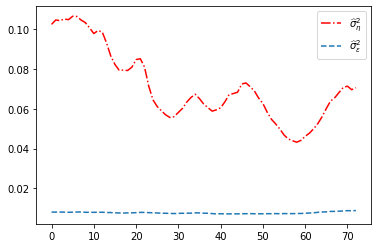

In [24]:
## plot estimation of UCSV model quarterly 
date_historyQ = np.array(list(CPICQ.index[n_burn_rt_historyQ:]) )

## stochastic vols
plt.plot(history_vol_etaQ,'r-.',
         label = r'$\widehat\sigma^2_{\eta}$')
plt.plot(history_vol_epsQ,'--',
         label = r'$\widehat\sigma^2_{\epsilon}$')
plt.legend(loc = 0)

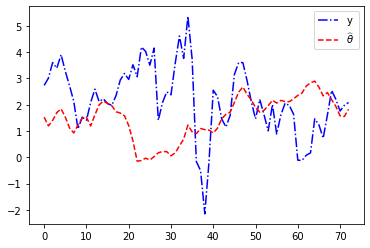

In [25]:
## inflation and the permanent component quarterly 

#plt.plot(np.array(CPICQ),
#         'r-.',
#         label = 'y')
         
#plt.plot(np.array(historyQ['RTCPICore']),
#         'r-.',
#         label = 'y')

#plt.plot(np.array(CPICQ_UCSV_Est['tau']),
#         '--',
#         label = r'$\widehat\theta$')


plt.plot(np.array(historyQ['RTCPICore']),
         'b-.',
         label = 'y')

plt.plot(np.array(history_etaQ),
        'r--',
        label = r'$\widehat\theta$')

plt.legend(loc = 0)

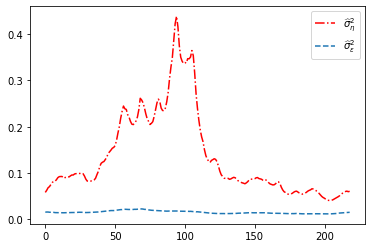

In [26]:
## Plot estimation of UCSV model monthly

date_historyM = np.array(list(CPIM.index[n_burn_rt_historyM:]) )

## stochastic vols
plt.plot(history_vol_etaM,'r-.',label=r'$\widehat\sigma^2_{\eta}$')
plt.plot(history_vol_epsM,'--',label=r'$\widehat\sigma^2_{\epsilon}$')
plt.legend(loc = 0)

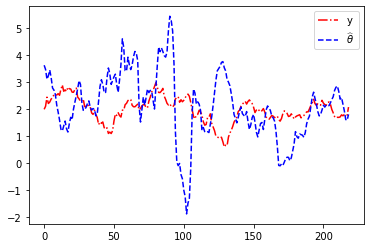

In [27]:
## inflation and the permanent component monthly 

plt.plot(np.array(historyM['RTCPI']),
         'r-.',
         label='y')
plt.plot(history_etaM,
         'b--',
         label=r'$\widehat\theta$')
plt.legend(loc = 0)

In [28]:
## preparing for data moments  

## quarterly 
exp_data_SPF = SPF_est[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data_SPF.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SPF = dict(exp_data_SPF)

exp_data_SCE = SCE_est[['SCE_Mean','SCE_FE','SCE_Disg','SCE_Var']]
exp_data_SCE.columns = ['Forecast','FE','Disg','Var']
data_moms_dct_SCE = dict(exp_data_SCE)

### SE Estimation

#### SPF

moments used include ['FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 6.622556
         Iterations: 116
         Function evaluations: 234
moments used include ['DisgATV', 'DisgVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 5.368178
         Iterations: 71
         Function evaluations: 142
moments used include ['DisgATV', 'FEATV', 'Var']
Optimization terminated successfully.
         Current function value: 5.443299
         Iterations: 104
         Function evaluations: 208
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV', 'Var']
Optimization terminated successfully.
         Current function value: 6.879225
         Iterations: 70
         Function evaluations: 140
[]
[array([0.46491631, 2.52498699]), array([0.45885818, 2.52503375]), array([ 0.4648352 , -1.26065985]), array([ 0.4586035 , -1.25727959])]


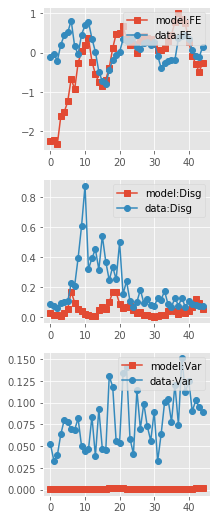

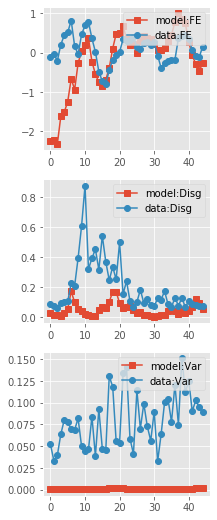

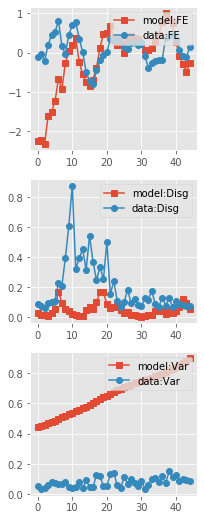

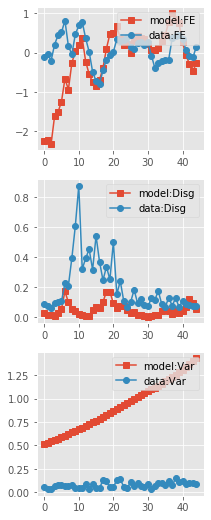

In [29]:
## SE SMM loop estimation over different choieces of moments for SPF

moments_choices_short = [['FEVar','FEATV','DisgVar','DisgATV','Var']]
moments_choices = [['FEVar','FEATV'],
                   ['DisgATV','DisgVar','FEATV'],
                   ['DisgATV','FEATV','Var'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]

para_est_SPF_holder = []
para_est_SPF_joint_holder = []

real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']
data_moms_dct = data_moms_dct_SPF
################################################################################
process_paraQ_try = {'gamma':0.01,
                     'eta0': 0.1}   ## this does not matter basically 
################################################################################
history_dct = {'eta':history_etaQ,
               'vols':history_volsQ,
               'y':history_Q}
real_time_dct = {'eta':real_time_etaQ,
                 'vols':real_time_volsQ,
                 'y':real_time}
SE_model = sesv(real_time = real_time_dct,
                history = history_dct,
                process_para = process_paraQ_try)

SE_model.GetRealization(realized_CPIC)
SE_model.GetDataMoments(data_moms_dct)

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    
    SE_model.moments = moments_to_use
    
    # only expectation
    #####################################################################
    #SE_model.ParaEstimateSMM(method='Nelder-Mead',
    #                         para_guess = np.array([0.3]),
    #                         options={'disp':True})
    ####################################################################
    #para_est_SPF_holder.append(SE_model.para_estSMM)
    #SE_model.all_moments = ['FE','Disg','Var']
    #SE_model.ForecastPlotDiag(how = 'SMM',
    #                          all_moms = True,
    #                          diff_scale = True)
    #plt.savefig('figures/spf_se_est_sv_diag'+str(i)+'.png')
    
    # joint estimate
    SE_model.ParaEstimateSMMJoint(method='Nelder-Mead',
                                  para_guess =(0.4,0.1),
                                  options={'disp':True})
    para_est_SPF_joint_holder.append(SE_model.para_est_SMM_joint)
    SE_model.all_moments = ['FE','Disg','Var']
    SE_model.ForecastPlotDiag(how = 'SMMjoint',
                              all_moms = True)
    plt.savefig('figures/spf_se_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

In [36]:
## tabulate the estimates 
#spf_se_est_para = pd.DataFrame(para_est_SPF_holder,columns=[r'SE: $\hat\lambda_{SPF}$(Q)'])
spf_se_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
                                     columns=[r'SE: $\hat\lambda_{SPF}$(Q)',
                                              r'SE: $\gamma$'])

In [37]:
spf_se_joint_est_para

,SE: $\hat\lambda_{SPF}$(Q),SE: $\gamma$
0,0.464916,2.524987
1,0.458858,2.525034
2,0.464835,-1.260660
3,0.458603,-1.257280


In [38]:
spf_se_est_para

,SE: $\hat\lambda_{SPF}$(Q)


#### SCE

moments used include ['DisgATV', 'Var']
Optimization terminated successfully.
         Current function value: 1.968045
         Iterations: 53
         Function evaluations: 106
moments used include ['FEATV', 'DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 2.176859
         Iterations: 29
         Function evaluations: 72
moments used include ['DisgATV', 'FEATV', 'Var']


ValueError: Domain error in arguments.

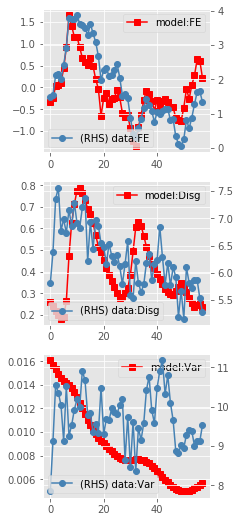

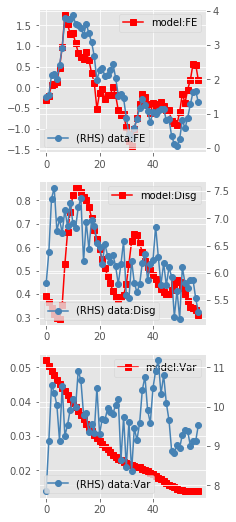

In [44]:
## SE loop estimation over different choieces of moments for SCE

moments_choices_short = [['FEATV','DisgVar','DisgATV']]
moments_choices = [['DisgATV','Var'],
                   ['FEATV','DisgVar','DisgATV'],
                   ['DisgATV','FEATV','Var']
                  ]

para_est_SCE_holder = []
para_est_SCE_joint_holder =[]


## initiate an instance 

real_time = np.array(SCE_est['RTCPI'])
history_M = historyM['RTCPI']
data_moms_dct = data_moms_dct_SCE

################################################################################
process_paraM_try = {'gamma':0.1,
                     'eta0': 0.1}   ## this does not matter basically 
################################################################################
history_dct = {'eta':history_etaM,
               'vols':history_volsM,
               'y':history_M}
real_time_dct = {'eta':real_time_etaM,
                 'vols':real_time_volsM,
                 'y':real_time}
SE_model2 = sesv(real_time = real_time_dct,
                 history = history_dct,
                 process_para = process_paraM_try)

SE_model2.GetRealization(realized_CPI)
SE_model2.GetDataMoments(data_moms_dct)
    
for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    SE_model2.moments = moments_to_use
    
    ## only expectation
    #SE_model2.ParaEstimateSMM(method='Nelder-Mead',
    #                          para_guess =np.array([0.1]),
    #                          options={'disp':True})
    #para_est_SCE_holder.append(SE_model2.para_estSMM)
    #SE_model2.all_moments = ['FE','Disg','Var']
    #SE_model2.ForecastPlotDiag(how = 'SMM',
    #                           all_moms = True,
    #                           diff_scale = True)
    #plt.savefig('figures/sce_se_est_sv_diag'+str(i)+'.png')
    
    ## joint estimation
    
    SE_model2.ParaEstimateSMMJoint(method='Nelder-Mead',
                                para_guess =(0.1,0.2),
                                options={'disp':True})
    para_est_SCE_joint_holder.append(SE_model2.para_est_SMM_joint)
    SE_model2.all_moments = ['FE','Disg','Var']
    SE_model2.ForecastPlotDiag(how ='SMMjoint',
                               all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_se_est_sv_joint_diag'+str(i)+'.png')

print(para_est_SCE_holder)
print(para_est_SCE_joint_holder)

In [47]:
#sce_se_est_para = pd.DataFrame(para_est_SCE_holder,
#                               columns = [r'SE: $\hat\lambda_{SCE}$(M)'])
sce_se_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
                                     columns = [r'SE: $\hat\lambda_{SCE}$(M)',
                                                r'SE: $\gamma$'])

In [48]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
se_est_df = pd.concat([est_moms,
                       spf_se_est_para,
                       sce_se_est_para],
                      join='inner', axis=1)

In [55]:
sce_se_joint_est_para

,SE: $\hat\lambda_{SCE}$(M),SE: $\gamma$
0,0.093631,0.702143
1,0.072640,0.259562


In [56]:
#sce_se_joint_est_para

In [57]:
se_est_df.to_excel('tables/SE_Est_sv.xlsx',
                   float_format='%.2f',
                   index=False)

### NI Estimation 
#### SPF

In [48]:
## NI loop estimation overdifferent choieces of moments for SPF

moments_choices_short = [['FEVar','FEATV','DisgVar','DisgATV']]
moments_choices = [['FEVar','FEATV'],
                   ['DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV'],
                   ['FEVar','FEATV','DisgVar','DisgATV','Var']
                  ]



para_est_SPF_holder = []
para_est_SPF_joint_holder = []


## initiate an instance 

real_time = np.array(SPF_est['RTCPI'])
history_Q = historyQ['RTCPICore']
data_moms_dct = data_moms_dct_SPF
################################################################################
process_paraQ_try = {'gamma':1,
                     'eta0': 0.1}   ## this does not matter basically 
################################################################################
history_dct = {'eta':history_etaQ,
               'vols':history_volsQ,
               'y':history_Q}
real_time_dct = {'eta':real_time_etaQ,
                 'vols':real_time_volsQ,
                 'y':real_time}
NI_model = nisv(real_time = real_time_dct,
              history = history_dct,
              process_para = process_paraQ_try)
#NI_model.SimulateSignals()
NI_model.GetRealization(realized_CPIC)
NI_model.GetDataMoments(data_moms_dct)

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    NI_model.moments = moments_to_use
    
    # only expectation
    #NI_model.ParaEstimateSMM(method='Nelder-Mead',
    #                         para_guess =(0.5,0.5),
    #                         options={'disp':True})
    #para_est_SPF_holder.append(NI_model.para_estSMM)
    #NI_model.all_moments = ['FE','Disg','Var']
    #NI_model.ForecastPlotDiag(how = 'SMM',
    #                          all_moms = True,
    #                          diff_scale = True)
    #plt.savefig('figures/spf_ni_est_sv_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model.ParaEstimateSMMJoint(method='Nelder-Mead',
    #                           para_guess =(0.5,0.5,0.1),
    #                           options={'disp':True})
    #para_est_SPF_joint_holder.append(NI_model.para_estSMM_joint)
    #NI_model.all_moments = ['FE','Disg','Var']
    #NI_model.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/spf_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
print(para_est_SPF_joint_holder)

moments used include ['FEVar', 'FEATV']
Optimization terminated successfully.
         Current function value: 0.154267
         Iterations: 69
         Function evaluations: 128
moments used include ['DisgVar', 'DisgATV']
Optimization terminated successfully.
         Current function value: 1.413623
         Iterations: 158
         Function evaluations: 352
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV']
moments used include ['FEVar', 'FEATV', 'DisgVar', 'DisgATV', 'Var']
Optimization terminated successfully.
         Current function value: 1.424096
         Iterations: 83
         Function evaluations: 152
[array([6.38902516, 4.06694094]), array([2.73412473e+06, 1.39884683e+00]), array([3.74756639e+10, 4.79582259e+00]), array([3.33193441, 1.71236742])]
[]


In [49]:
## tabulate the estimates 
spf_ni_est_para = pd.DataFrame(para_est_SPF_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SPF}$',
                                        r'$\hat\sigma_{pr,SPF}$'])
#spf_ni_joint_est_para = pd.DataFrame(para_est_SPF_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SPF}$',
#                                              r'$\hat\sigma_{pr,SPF}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])

In [50]:
spf_ni_est_para

,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$"
0,6.389025e+00,4.066941
1,2.734125e+06,1.398847
2,3.747566e+10,4.795823
3,3.331934e+00,1.712367


#### SCE

moments used include ['Forecast']
moments used include ['FE']
moments used include ['FE', 'Disg']
moments used include ['FE', 'Var']
moments used include ['FE', 'Disg', 'Var']
[array([16.89948447, 21.44381516,  0.        ,  1.        ,  5.        ]), array([ 67.05408486, 146.7960184 ,   0.        ,   1.        ,
         5.        ]), array([62.60397664,  0.56607173,  0.        ,  1.        ,  5.        ]), array([7.87166152e+02, 3.25783770e+03, 5.57684166e-02, 1.00000000e+00,
       5.00000000e+00]), array([126.68225741,   0.5650482 ,   0.        ,   1.        ,
         5.        ])]


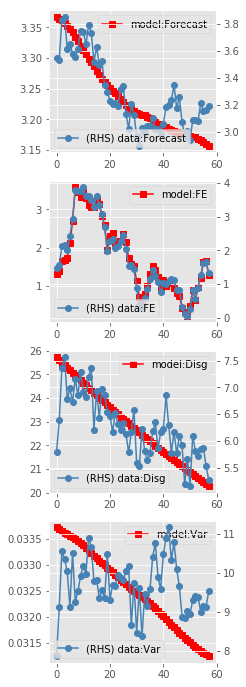

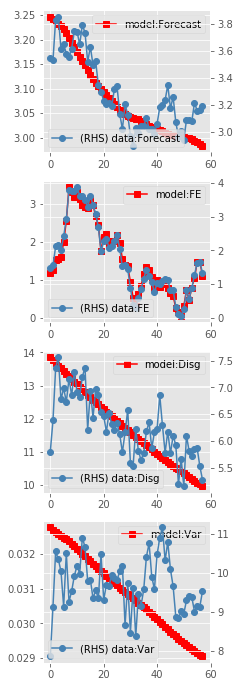

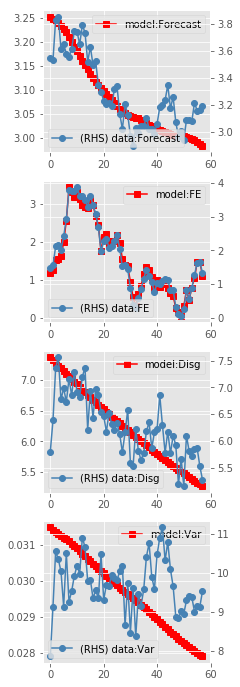

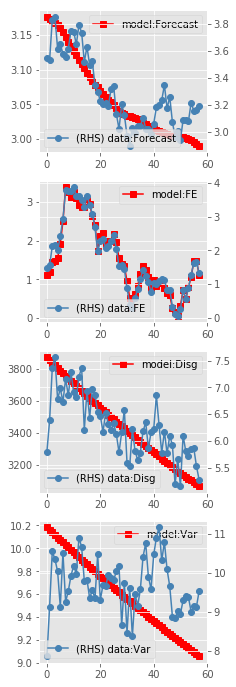

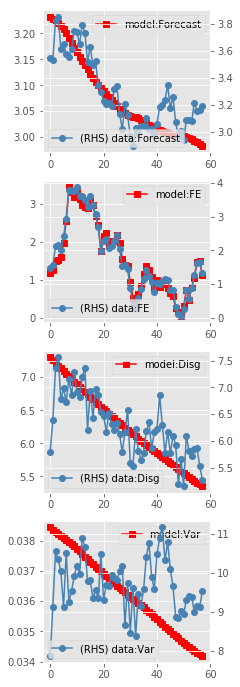

In [35]:
## NI loop estimation overdifferent choieces of moments for SCE

moments_choices_short = [['Forecast']]
moments_choices = [['Forecast'],
                   ['FE'],
                   ['FE','Disg'],
                   ['FE','Var'],
                   ['FE','Disg','Var']]

para_est_SCE_holder = []
para_est_SCE_joint_holder = []

### loop starts from here for SPF 

for i,moments_to_use in enumerate(moments_choices):
    print("moments used include "+ str(moments_to_use))
    real_time = np.array(SCE_est['RTCPI'])
    history_M = historyM['RTCPI']
    data_moms_dct = data_moms_dct_SCE
    ################################################################################
    process_paraM_try = {'gamma': 10,
                         'eta0': 0.1}   ## this does not matter basically 
    ################################################################################
    history_dct = {'eta':history_etaM,
                   'vols':history_volsM,
                   'y':history_M}
    real_time_dct = {'eta':real_time_etaM,
                   'vols':real_time_volsM,
                   'y':real_time}
    NI_model2 = ni(real_time = real_time_dct,
                   history = history_dct,
                   process_para = process_paraM_try)
    NI_model2.SimulateSignals()
    NI_model2.moments = moments_to_use
    NI_model2.GetRealization(realized_CPI)
    NI_model2.GetDataMoments(data_moms_dct)
    
    # only expectation
    NI_model2.ParaEstimate(method='L-BFGS-B',
                           para_guess =(1,1,0.5,1,2),
                           bounds =((0,None),(0,None),(0,None),(None,None),(0,None)),
                           options={'disp':True})
    para_est_SCE_holder.append(NI_model2.para_est)
    NI_model2.all_moments = ['Forecast','FE','Disg','Var']
    NI_model2.ForecastPlotDiag(all_moms = True,
                               diff_scale = True)
    plt.savefig('figures/sce_ni_est_sv_diag'+str(i)+'.png')
    
    # joint estimate
    #NI_model2.ParaEstimateJoint(method='L-BFGS-B',
    #                           para_guess =(0.5,0.5,0.1,0.8,0.1),
    #                           bounds = ((0,None),(0,None),(0,None),(0,1),(0,None)),
    #                           options={'disp':True})
    #para_est_SCE_joint_holder.append(NI_model2.para_est_joint)
    #NI_model.all_moments = ['Forecast','FE','Disg','Var']
    #NI_model2.ForecastPlotDiagJoint(all_moms = True)
    #plt.savefig('figures/sce_ni_est_joint_diag'+str(i)+'.png')
    
print(para_est_SPF_holder)
#print(para_est_SPF_joint_holder)

In [52]:
## tabulate the estimates 
sce_ni_est_para = pd.DataFrame(para_est_SCE_holder,
                               columns=[r'NI: $\hat\sigma_{pb,SCE}$',
                                        r'$\hat\sigma_{pr,SCE}$',
                                        r'$Var$',
                                        r'$y$',
                                        'Disg'])
#sce_ni_joint_est_para = pd.DataFrame(para_est_SCE_joint_holder,
#                                     columns=[r'NI: $\hat\sigma_{pb,SCE}$',
#                                              r'$\hat\sigma_{pr,SCE}$',
#                                              r'$Var$',
#                                              r'NI: $\rho$',
#                                              r'NI: $\sigma$'])


In [53]:
sce_ni_est_para

,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",$Var$,$y$,Disg


In [42]:
est_moms = pd.DataFrame(moments_choices)

## combining SCE and SPF 
ni_est_df = pd.concat([est_moms,
                       spf_ni_est_para,
                       sce_ni_est_para],
                      join='inner', axis=1)

In [44]:
ni_est_df

,0,1,2,"NI: $\hat\sigma_{pb,SPF}$","$\hat\sigma_{pr,SPF}$",$Var$,$y$,Disg,"NI: $\hat\sigma_{pb,SCE}$","$\hat\sigma_{pr,SCE}$",$Var$,$y$,Disg
0,Forecast,None,None,16.899484,21.443815,0.000000,1.0,5.0,5.212725,6.051031,0.000000,1.0,2.0
1,FE,None,None,67.054085,146.796018,0.000000,1.0,5.0,4.404315,4.882138,0.001561,1.0,2.0
2,FE,Disg,None,62.603977,0.566072,0.000000,1.0,5.0,7.234679,3.535202,0.000000,1.0,2.0
3,FE,Var,None,787.166152,3257.837701,0.055768,1.0,5.0,97.716918,95.731000,15.613889,1.0,2.0
4,FE,Disg,Var,126.682257,0.565048,0.000000,1.0,5.0,215.539961,3.644605,0.009055,1.0,2.0


In [43]:
ni_est_df.to_excel('tables/NI_Est_sv.xlsx',
                   float_format='%.2f',
                   index=False)

In [45]:
### Estimate of Parameter Learning for SPF

real_time = np.array(SPF_est['RTCPI'])
data_moms_dct = data_moms_dct_SPF

#process_paraQ_est = {'rho':rhoQ_est,
#                    'sigma':sigmaQ_est}

PL_model = pl(real_time = real_time,
              history = history_Q,
              process_para = process_paraQ_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model.GetRealization(realized_CPIC)
PL_model.LearnParameters()
moms_pl_sim = PL_model.Forecaster()
PL_model.GetDataMoments(data_moms_dct)

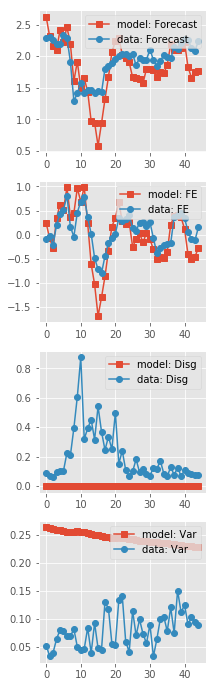

In [46]:
pl_plot = ForecastPlotDiag(moms_pl_sim,
                           data_moms_dct,
                           legends=['model','data'])

In [66]:
### Estimate of Parameter Learning for SCE

"""
real_time = np.array(SCE_est['RTCPI'])
data_moms_dct2 = data_moms_dct_SCE

process_paraM_est = {'rho':rhoM_est,
                    'sigma':sigmaM_est}

PL_model2 = pl(real_time = real_time,
              history = history_M,
              process_para = process_paraM_est,
              moments = ['Forecast','FE','Disg','Var'])

PL_model2.GetRealization(realized_CPI)
PL_model2.LearnParameters()
moms_pl_sim2 = PL_model2.Forecaster()
PL_model2.GetDataMoments(data_moms_dct2)

"""

"\nreal_time = np.array(SCE_est['RTCPI'])\ndata_moms_dct2 = data_moms_dct_SCE\n\nprocess_paraM_est = {'rho':rhoM_est,\n                    'sigma':sigmaM_est}\n\nPL_model2 = pl(real_time = real_time,\n              history = history_M,\n              process_para = process_paraM_est,\n              moments = ['Forecast','FE','Disg','Var'])\n\nPL_model2.GetRealization(realized_CPI)\nPL_model2.LearnParameters()\nmoms_pl_sim2 = PL_model2.Forecaster()\nPL_model2.GetDataMoments(data_moms_dct2)\n\n"